# Libraries

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, date

from pvlib import solarposition
from scipy.optimize import minimize_scalar

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Aesthetics

In [15]:
scaler = 2
fig_wide = 6.267717 * scaler # width of a4 minus 2.54cm margins either side then x by scaler to scale everything"s size easily
fig_gold = 1.618

# Data Import

## Functions

In [64]:
# Convert timestamps to datetimes
def convert_time(dataframe, column, format = None, unit = None, new_name = "Time (Datetime)"):
    dataframe[new_name] = pd.to_datetime(dataframe[column], format = format, unit = unit)
    #dataframe.rename(columns = {column: new_name}, inplace = True)

# Clean data
def cleaner(dataframe, variable_name):
    dataframe[variable_name] = dataframe[variable_name].replace([-9999.0], np.nan) # Replace visible/known missing values
    dataframe = dataframe.reindex(pd.date_range(start = dataframe.index[0], end = dataframe.index[-1], freq = "30min")) # Reindex to deal with hidden missing values
    #dataframe.index.name = "date" # put the name of the index column back!
    dataframe = dataframe[[variable_name]].copy() # Select Variables
    return dataframe

def calc_time_by_solar(latitude, longitude, date, target_elevation, target_azimuth):

    # Minimize the difference in solar position
    def objective(mins_since_midnight):
        dt = date + pd.Timedelta(minutes = mins_since_midnight)
        pos = solarposition.get_solarposition(dt, latitude, longitude)
        elev = pos['apparent_elevation'].values[0]
        azim = pos['azimuth'].values[0]
        return (elev - target_elevation)**2 + (azim - target_azimuth)**2
    
    # Optimize over a 24-hour period
    res = minimize_scalar(objective, bounds = (0, 1440), method = 'bounded') # using 1440 for number of mins in 24 hours. Don't need more resolution than this
    recovered_datetime = date + pd.Timedelta(minutes = res.x) # Get the time of day (res.x) and add it to the input date.
    
    return recovered_datetime

def convert_azimuth2(dataframe, column):
    for idx, azimuth in enumerate(dataframe[column]):
        # If azimuth is less than 0, add 360 to make it in the 0 to 360 range.
        if azimuth < 0:
            dataframe.at[idx, column] = azimuth + 360

def convert_azimuth(azimuth):
    # If azimuth's are from -180 to 0 range then add 360 to make them in the 0 to 360 range. Don't do anything to values below above 0.
    if azimuth < 0:
        azimuth += 360
    return azimuth

## Flux Tower Eddy Covariance

In [19]:
# Import flux data
flux = {
    
    # Abisko-Stordalen Palsa Bog flux data
    "Se_Sto": pd.read_csv(
        "../data/flux/abisko-stordalen-palsa-bog/ICOSETC_SE-Sto_FLUXNET_HH_L2.csv", 
        usecols = [
            "TIMESTAMP_END",
            "GPP_DT_VUT_REF", # gross primary production
            "SWC_F_MDS_1", # soil water content at depth 1, gap-filled with MDS
            "SWC_F_MDS_2", # soil water content at depth 2, gap-filled with MDS
            "SWC_F_MDS_3", # soil water content at depth 3, gap-filled with MDS
            "SWC_F_MDS_4", # soil water content at depth 4, gap-filled with MDS
            "SWC_F_MDS_5", # soil water content at depth 5, gap-filled with MDS
            "SWC_F_MDS_6" # soil water content at depth 6, gap-filled with MDS
        ]
    ),

    # Kenttarova flux data
    "Fi_Ken": pd.read_csv(
        "../data/flux/kenttarova/ICOSETC_FI-Ken_FLUXNET_HH_L2.csv",
        usecols = [
            "TIMESTAMP_END",
            "GPP_DT_VUT_REF", # gross primary production
            "SWC_F_MDS_1", # soil water content at depth 1, gap-filled with MDS
            "SWC_F_MDS_2" # soil water content at depth 2, gap-filled with MDS
        ]
    ),

    # Sodankyla flux data
    "Fi_Sod": pd.read_csv(
        "../data/flux/sodankyla/ICOSETC_FI-Sod_FLUXNET_HH_L2.csv",
        usecols = [
            "TIMESTAMP_END",
            "GPP_DT_VUT_REF", # gross primary production
            "SWC_F_MDS_1", # soil water content at depth 1, gap-filled with MDS
            "SWC_F_MDS_2", # soil water content at depth 2, gap-filled with MDS
            "SWC_F_MDS_3", # soil water content at depth 3, gap-filled with MDS
            "SWC_F_MDS_4", # soil water content at depth 4, gap-filled with MDS
            "SWC_F_MDS_5" # soil water content at depth 5, gap-filled with MDS
        ]
    ),

    # Varrio flux data
    "Fi_Var": pd.read_csv(
        "../data/flux/varrio/ICOSETC_FI-Var_FLUXNET_HH_L2.csv",
        usecols = [
            "TIMESTAMP_END",
            "GPP_DT_VUT_REF", # gross primary production
            "SWC_F_MDS_1", # soil water content at depth 1, gap-filled with MDS
            "SWC_F_MDS_2", # soil water content at depth 2, gap-filled with MDS
        ]
    )

}

# Rename Columns
flux["Se_Sto"].rename(columns = {
    "TIMESTAMP_END": "Time (Unix)",
    "GPP_DT_VUT_REF": "Gross Primary Production (µmol)",
    "SWC_F_MDS_1": "Soil Water Content Depth 1 (%)",
    "SWC_F_MDS_2": "Soil Water Content Depth 2 (%)",
    "SWC_F_MDS_3": "Soil Water Content Depth 3 (%)",
    "SWC_F_MDS_4": "Soil Water Content Depth 4 (%)",
    "SWC_F_MDS_5": "Soil Water Content Depth 5 (%)",
    "SWC_F_MDS_6": "Soil Water Content Depth 6 (%)"
    }, inplace=True)
flux["Fi_Ken"].rename(columns = {
    "TIMESTAMP_END": "Time (Unix)",
    "GPP_DT_VUT_REF": "Gross Primary Production (µmol)",
    "SWC_F_MDS_1": "Soil Water Content Depth 1 (%)",
    "SWC_F_MDS_2": "Soil Water Content Depth 2 (%)"
    }, inplace=True)
flux["Fi_Sod"].rename(columns = {
    "TIMESTAMP_END": "Time (Unix)",
    "GPP_DT_VUT_REF": "Gross Primary Production (µmol)",
    "SWC_F_MDS_1": "Soil Water Content Depth 1 (%)",
    "SWC_F_MDS_2": "Soil Water Content Depth 2 (%)",
    "SWC_F_MDS_3": "Soil Water Content Depth 3 (%)",
    "SWC_F_MDS_4": "Soil Water Content Depth 4 (%)",
    "SWC_F_MDS_5": "Soil Water Content Depth 5 (%)"
    }, inplace=True)
flux["Fi_Var"].rename(columns = {
    "TIMESTAMP_END": "Time (Unix)",
    "GPP_DT_VUT_REF": "Gross Primary Production (µmol)",
    "SWC_F_MDS_1": "Soil Water Content Depth 1 (%)",
    "SWC_F_MDS_2": "Soil Water Content Depth 2 (%)"
    }, inplace=True)

# Run Pre-processing
for location, dataframe in flux.items():
    convert_time(dataframe, "Time (Unix)", "%Y%m%d%H%M") # Convert unix timestamps to datetimes
    dataframe = dataframe.set_index("Time (Datetime)", drop = False) # Make the new datetime column the index
    dataframe.sort_index(inplace = True) # Sort by time
    dataframe = pd.concat([cleaner(dataframe[[column]].copy(), column) for column in dataframe.columns], axis = 1) # Clean and reassign dataFrame
    dataframe["Time (Time of Day)"] = [datetime.combine(date.today(), t) for t in dataframe["Time (Datetime)"].dt.time] # Add Time of Day. https://stackoverflow.com/questions/32832431/how-to-use-datetime-time-to-plot
    dataframe["Time (Day of Year)"] = dataframe["Time (Datetime)"].dt.dayofyear # Add Day of Year. Returns 1 for January 1st
    dataframe["Time (Unix)"] = dataframe["Time (Time of Day)"].astype(int) / 10**9 # Remake unix time from datetime (we"re remaking it so the flux and satellite unix times are the same length)
    flux[location] = dataframe
    
# Preview
flux["Se_Sto"]

,Time (Unix),Soil Water Content Depth 1 (%),Soil Water Content Depth 2 (%),Soil Water Content Depth 3 (%),Soil Water Content Depth 4 (%),Soil Water Content Depth 5 (%),Soil Water Content Depth 6 (%),Gross Primary Production (µmol),Time (Datetime),Time (Time of Day),Time (Day of Year)
2022-01-01 00:30:00,1.746664e+09,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-01-01 00:30:00,2025-05-08 00:30:00,1
2022-01-01 01:00:00,1.746666e+09,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-01-01 01:00:00,2025-05-08 01:00:00,1
2022-01-01 01:30:00,1.746668e+09,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-01-01 01:30:00,2025-05-08 01:30:00,1
2022-01-01 02:00:00,1.746670e+09,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-01-01 02:00:00,2025-05-08 02:00:00,1
2022-01-01 02:30:00,1.746671e+09,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2022-01-01 02:30:00,2025-05-08 02:30:00,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 22:00:00,1.746742e+09,1.61,1.22,0.0,8.18,29.15,26.04,0.0,2024-12-31 22:00:00,2025-05-08 22:00:00,366
2024-12-31 22:30:00,1.746743e+09,1.47,1.12,0.0,8.14,29.07,26.05,0.0,2024-12-31 22:30:00,2025-05-08 22:30:00,366
2024-12-31 23:00:00,1.746745e+09,1.63,1.19,0.0,8.19,29.11,26.12,0.0,2024-12-31 23:00:00,2025-05-08 23:00:00,366
2024-12-31 23:30:00,1.746747e+09,1.60,1.21,0.0,8.30,29.10,26.12,0.0,2024-12-31 23:30:00,2025-05-08 23:30:00,366


Preview Primary Production Data

Text(0.02, 0.5, 'Daytime Gross Primary Production (µmol CO$^2$ m$^-$$^2$ s$^-$$^1$)')

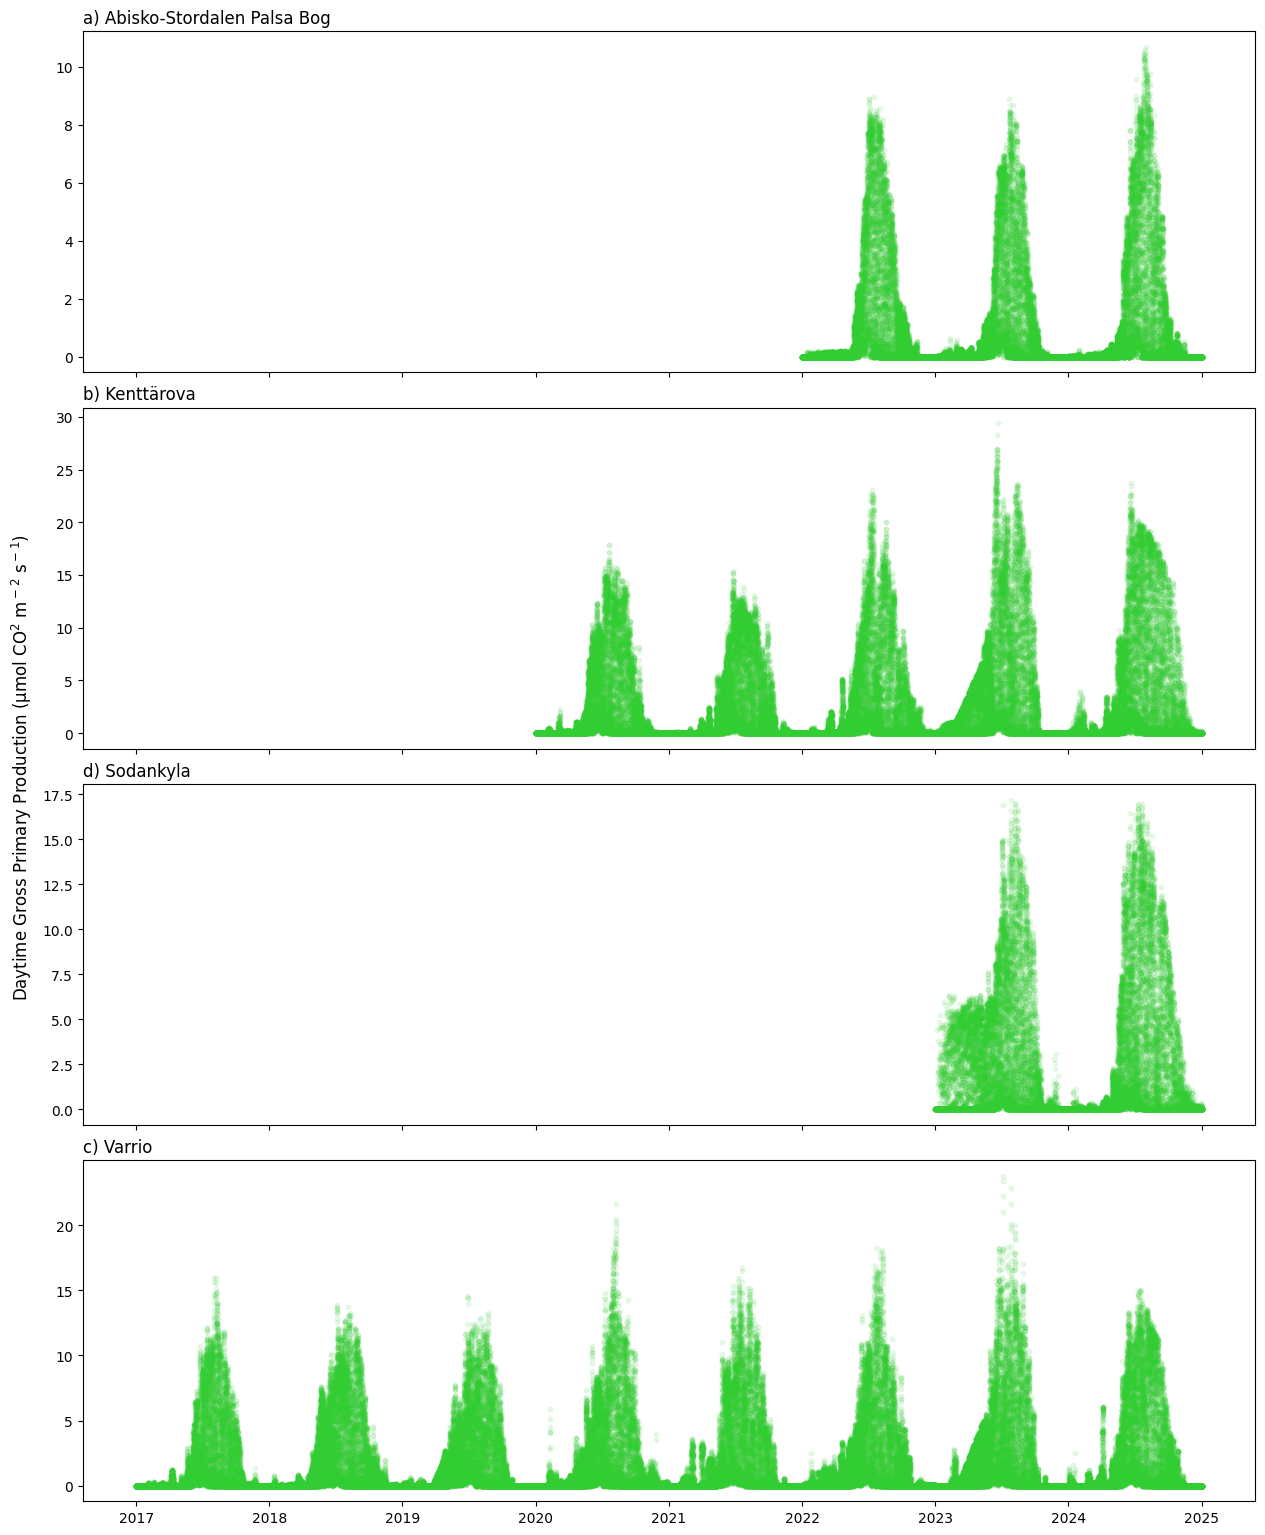

In [20]:
nrows = 4
ncols = 1
squish_factor = 8
fig, ax = plt.subplots(
    nrows = nrows, ncols = ncols, 
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = True, constrained_layout = True
)
ax = ax.flatten()

ax[0].scatter(
    x = flux["Se_Sto"]["Time (Datetime)"], y = flux["Se_Sto"]["Gross Primary Production (µmol)"],
    c = "limegreen", s = 10, alpha = 0.1, edgecolors = None
)
ax[0].set_title("a) Abisko-Stordalen Palsa Bog", loc = "left")

ax[1].scatter(
    x = flux["Fi_Ken"]["Time (Datetime)"], y = flux["Fi_Ken"]["Gross Primary Production (µmol)"],
    c = "limegreen", s = 10, alpha = 0.1, edgecolors = None
)
ax[1].set_title("b) Kenttärova", loc = "left")

ax[2].scatter(
    x = flux["Fi_Sod"]["Time (Datetime)"], y = flux["Fi_Sod"]["Gross Primary Production (µmol)"],
    c = "limegreen", s = 10, alpha = 0.1, edgecolors = None
)
ax[2].set_title("d) Sodankyla", loc = "left")

ax[3].scatter(
    x = flux["Fi_Var"]["Time (Datetime)"], y = flux["Fi_Var"]["Gross Primary Production (µmol)"],
    c = "limegreen", s = 10, alpha = 0.1, edgecolors = None
)
ax[3].set_title("c) Varrio", loc = "left")

fig.supylabel("Daytime Gross Primary Production (µmol CO$^2$ m$^-$$^2$ s$^-$$^1$)")

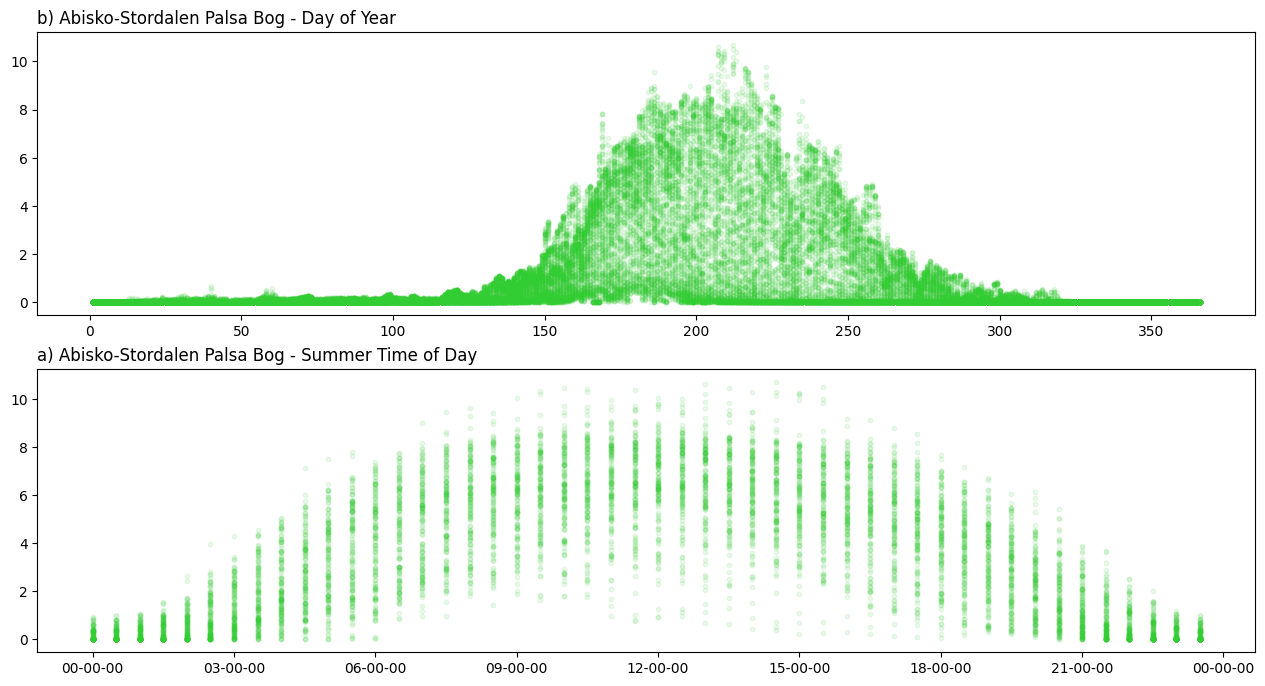

In [21]:
filtered = flux["Se_Sto"][(flux["Se_Sto"]["Time (Day of Year)"] > 175) & (flux["Se_Sto"]["Time (Day of Year)"] < 225)]

nrows = 2
ncols = 1
squish_factor = 1
fig, ax = plt.subplots(
    nrows = nrows, ncols = ncols, 
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = False, constrained_layout = True
)
ax = ax.flatten()

ax[0].scatter(
    x = flux["Se_Sto"]["Time (Day of Year)"], y = flux["Se_Sto"]["Gross Primary Production (µmol)"],
    c = "limegreen", s = 10, alpha = 0.1, edgecolors = None
)
ax[0].set_title("b) Abisko-Stordalen Palsa Bog - Day of Year", loc = "left")

ax[1].scatter(
    x = filtered["Time (Time of Day)"], y = filtered["Gross Primary Production (µmol)"],
    c = "limegreen", s = 10, alpha = 0.1, edgecolors = None
)
ax[1].set_title("a) Abisko-Stordalen Palsa Bog - Summer Time of Day", loc = "left")
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%H-%M-%S"))

Text(0.02, 0.5, 'Soil Water Content Depth 2 (%)')

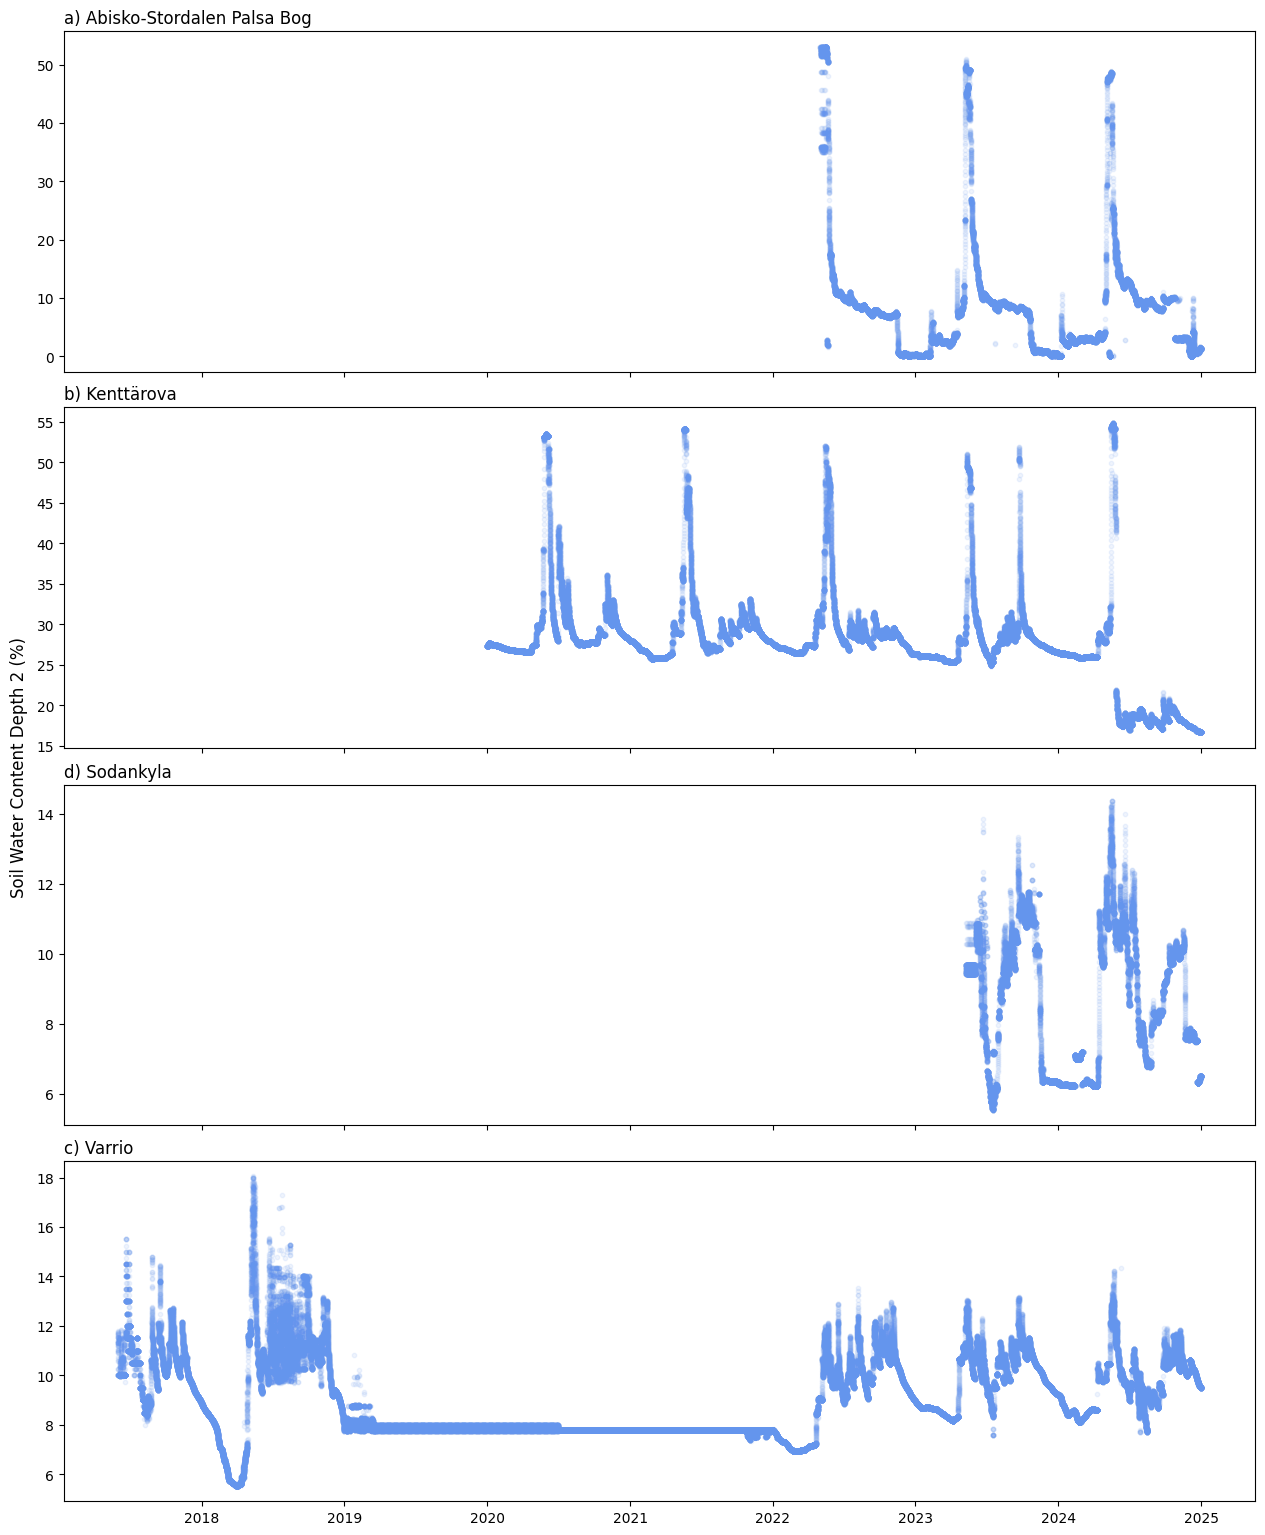

In [22]:
nrows = 4
ncols = 1
squish_factor = 8
fig, ax = plt.subplots(
    nrows = nrows, ncols = ncols, 
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = True, constrained_layout = True
)
ax = ax.flatten()

ax[0].scatter(
    x = flux["Se_Sto"]["Time (Datetime)"], y = flux["Se_Sto"]["Soil Water Content Depth 2 (%)"],
    c = "cornflowerblue", s = 10, alpha = 0.1, edgecolors = None
)
ax[0].set_title("a) Abisko-Stordalen Palsa Bog", loc = "left")

ax[1].scatter(
    x = flux["Fi_Ken"]["Time (Datetime)"], y = flux["Fi_Ken"]["Soil Water Content Depth 2 (%)"],
    c = "cornflowerblue", s = 10, alpha = 0.1, edgecolors = None
)
ax[1].set_title("b) Kenttärova", loc = "left")

ax[2].scatter(
    x = flux["Fi_Sod"]["Time (Datetime)"], y = flux["Fi_Sod"]["Soil Water Content Depth 2 (%)"],
    c = "cornflowerblue", s = 10, alpha = 0.1, edgecolors = None
)
ax[2].set_title("d) Sodankyla", loc = "left")

ax[3].scatter(
    x = flux["Fi_Var"]["Time (Datetime)"], y = flux["Fi_Var"]["Soil Water Content Depth 2 (%)"],
    c = "cornflowerblue", s = 10, alpha = 0.1, edgecolors = None
)
ax[3].set_title("c) Varrio", loc = "left")

fig.supylabel("Soil Water Content Depth 2 (%)")

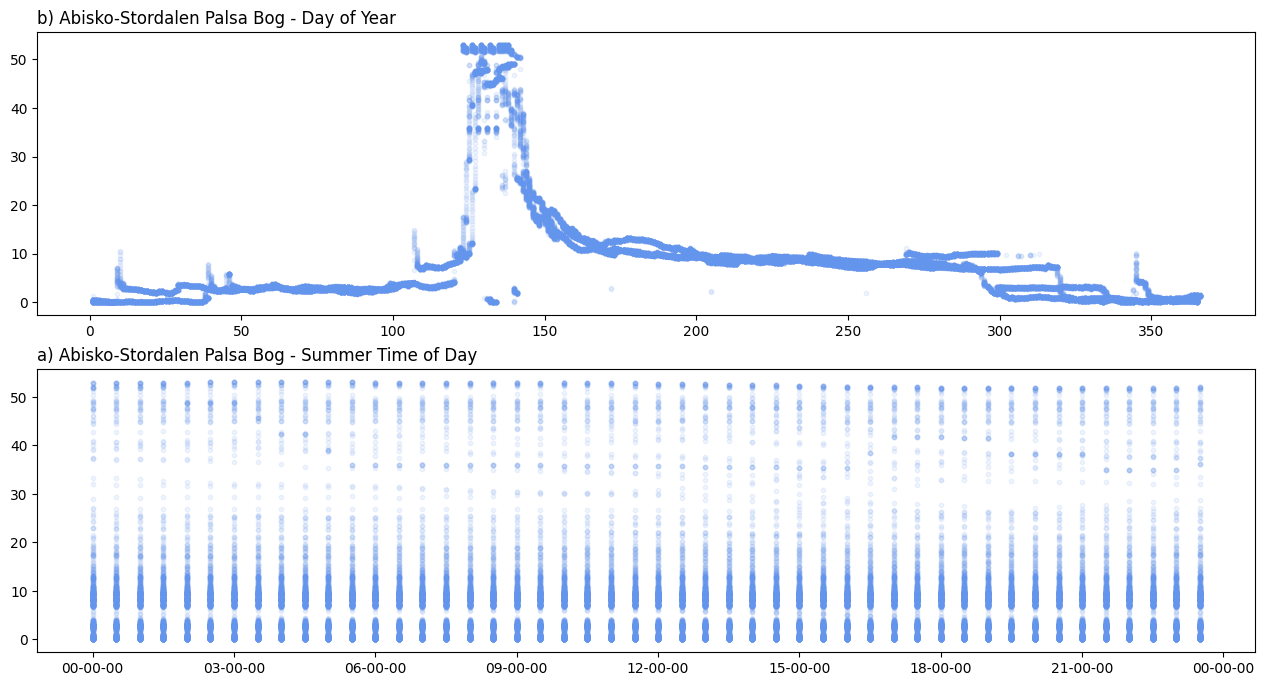

In [23]:
filtered = flux["Se_Sto"]#[(flux["Se_Sto"]["Time (Day of Year)"] > 175) & (flux["Se_Sto"]["Time (Day of Year)"] < 225)]

nrows = 2
ncols = 1
squish_factor = 1
fig, ax = plt.subplots(
    nrows = nrows, ncols = ncols, 
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = False, constrained_layout = True
)
ax = ax.flatten()

ax[0].scatter(
    x = flux["Se_Sto"]["Time (Day of Year)"], y = flux["Se_Sto"]["Soil Water Content Depth 2 (%)"],
    c = "cornflowerblue", s = 10, alpha = 0.1, edgecolors = None
)
ax[0].set_title("b) Abisko-Stordalen Palsa Bog - Day of Year", loc = "left")

ax[1].scatter(
    x = filtered["Time (Time of Day)"], y = filtered["Soil Water Content Depth 2 (%)"],
    c = "cornflowerblue", s = 10, alpha = 0.1, edgecolors = None
)
ax[1].set_title("a) Abisko-Stordalen Palsa Bog - Summer Time of Day", loc = "left")
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%H-%M-%S"))

## Satellite Data

In [ ]:
satellite = {

    "Se_Sto": pd.read_csv("../data/satellite/tundra-flux_data_viirs.csv")

}

# Rename Columns
satellite["Se_Sto"].rename(columns = {
    "time": "Time (Unix)",
    "solarElevation": "Solar Elevation (Degrees)",
    "solarAzimuth": "Solar Azimuth (Degrees)",
    "platformID": "Platform ID",
    "Red": "Red (Rad)",
    "NIR": "NIR (Rad)",
    "SWIR_1": "SWIR (Rad)",
    }, inplace = True)

# Run Pre-processing
for location, dataframe in satellite.items():
    convert_time(dataframe, "Time (Unix)", unit = "ms") # Convert unix timestamps to datetimes
    
    convert_azimuth2(dataframe, "Solar Azimuth (Degrees)")
    
    # Recover Time of Day from MODIS Solar Position
    # Filter the dataframe to satellites without time of day
    mask = dataframe["Platform ID"].isin(["MOD09GA", "MYD09GA", "VNP09GA"])
    masked_dataframe = dataframe.loc[mask]
    masked_dataframe["Time (Datetime)"] = masked_dataframe["Time (Datetime)"].dt.normalize() # Get the datetime ensure that time is removed (AKA set time to midnight). It should already be midnight but we do it just in case
    
    # Run Conversion
    for idx, row in masked_dataframe.iterrows():
        
        recovered_datetime = calc_time_by_solar(
            latitude = 68.35594288,
            longitude = 19.04520892,
            date = row["Time (Datetime)"],
            target_elevation = row["Solar Elevation (Degrees)"],
            target_azimuth = convert_azimuth(row["Solar Azimuth (Degrees)"])
            )
        
        #print(recovered_datetime)
        dataframe.loc[idx, "Time (Datetime)"] = recovered_datetime
    
    dataframe = dataframe.set_index("Time (Datetime)", drop = False) # Make the new datetime column the index
    dataframe["Time (Time of Day)"] = [datetime.combine(date.today(), t) for t in dataframe["Time (Datetime)"].dt.time] # Add Time of Day. https://stackoverflow.com/questions/32832431/how-to-use-datetime-time-to-plot
    dataframe["Time (Day of Year)"] = dataframe["Time (Datetime)"].dt.dayofyear # Add Day of Year. 1 is January 1st
    dataframe.sort_index(inplace = True)
    # No cleaning needed/possible as we have duplicate time values and I also made this data so I know it is clean.
    dataframe.rename_axis(None, inplace = True) # all we need to do is remove the index column header (otherwise using .merge won"t work)
    dataframe["Time (Unix)"] = dataframe["Time (Time of Day)"].astype(int) / 10**9 # Remake unix time from datetime (we"re remaking it so the flux and satellite unix times are the same length)
    
    # TEMPORARY - Satellite Filter
    dataframe = dataframe[dataframe["Platform ID"] != "AST_L1T_003"]
    #dataframe = dataframe[dataframe["Platform ID"] != "MOD09GA"]
    #dataframe = dataframe[dataframe["Platform ID"] != "MYD09GA"]
    #dataframe = dataframe[dataframe["Platform ID"] != "VNP09GA"]
    #dataframe = dataframe[dataframe["Platform ID"] != "LT04"]
    #dataframe = dataframe[dataframe["Platform ID"] != "LT05"]
    #dataframe = dataframe[dataframe["Platform ID"] != "LE07"]
    #dataframe = dataframe[dataframe["Platform ID"] != "LC08"]
    #dataframe = dataframe[dataframe["Platform ID"] != "LC09"]
    #dataframe = dataframe[dataframe["Platform ID"] != "S2_SR_HARMONIZED"]
    dataframe = dataframe[dataframe["Platform ID"] != "AVHRR"]
    
    # Make Vegetation Indices (chlorophyll-ness)
    dataframe["NDVI"] = (dataframe["NIR (Rad)"] - dataframe["Red (Rad)"]) / (dataframe["NIR (Rad)"] + dataframe["Red (Rad)"]) # NDVI
    dataframe = dataframe[(dataframe["NDVI"] > -1) & (dataframe["NDVI"] < 1)] # Clean by NDVI -1 to +1
    dataframe["MSAVI"] = (2 * dataframe["NIR (Rad)"] + 1 - np.sqrt((2 * dataframe["NIR (Rad)"] + 1)**2 - 8 * (dataframe["NIR (Rad)"] - dataframe["Red (Rad)"]))) / 2 # msavi
    dataframe["NIRv"] = ( (dataframe["NIR (Rad)"] - dataframe["Red (Rad)"]) / (dataframe["NIR (Rad)"] + dataframe["Red (Rad)"]) - 0.08 ) * dataframe["NIR (Rad)"] # NIRv
    dataframe["MSI"] = (dataframe["SWIR (Rad)"] / dataframe["NIR (Rad)"]) # MSI
    
    # Make Soil Moisture Indices (Plant water stress?)
    dataframe["NDWI"] = (dataframe["NIR (Rad)"] - dataframe["SWIR (Rad)"]) / (dataframe["NIR (Rad)"] + dataframe["SWIR (Rad)"]) # NDWI
    # MNDWI needs Green band dataframe["MNDWI"] = (dataframe["Green (Rad)"] - dataframe["SWIR (Rad)"]) / (dataframe["Green (Rad)"] + dataframe["SWIR (Rad)"]) # NDWI
    # RSWIR = RED - SWIR / RED + SWIR
    dataframe["GVMI"] = (dataframe["NIR (Rad)"] + 0.1 - dataframe["SWIR (Rad)"] + 0.02) /  (dataframe["NIR (Rad)"] + 0.1 + dataframe["SWIR (Rad)"] + 0.02) # GVMI
    
    # TEMPORARY - Modis Bias Correct
    #mask = dataframe["Platform ID"].isin(["MOD09GA", "MYD09GA"])
    #masked_dataframe = dataframe.loc[mask]
    #masked_dataframe["NDVI"] = masked_dataframe["NDVI"] + 0.2
    #dataframe.loc[dataframe['Platform ID'] == 'MOD09GA', 'NDVI'] += 0.2
    #dataframe.loc[dataframe['Platform ID'] == 'MYD09GA', 'NDVI'] += 0.2
    #
    #dataframe.loc[dataframe['Platform ID'] == 'MOD09GA', 'MSI'] -= 0.6
    #dataframe.loc[dataframe['Platform ID'] == 'MYD09GA', 'MSI'] -= 0.6
    
    satellite[location] = dataframe

satellite["Se_Sto"]

C:\Users\Laurie\AppData\Local\Temp\ipykernel_38892\3464083742.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masked_dataframe["Time (Datetime)"] = masked_dataframe["Time (Datetime)"].dt.normalize() # Get the datetime ensure that time is removed (AKA set time to midnight). It should already be midnight but we do it just in case


Preview

Text(0.02, 0.5, 'NDVI')

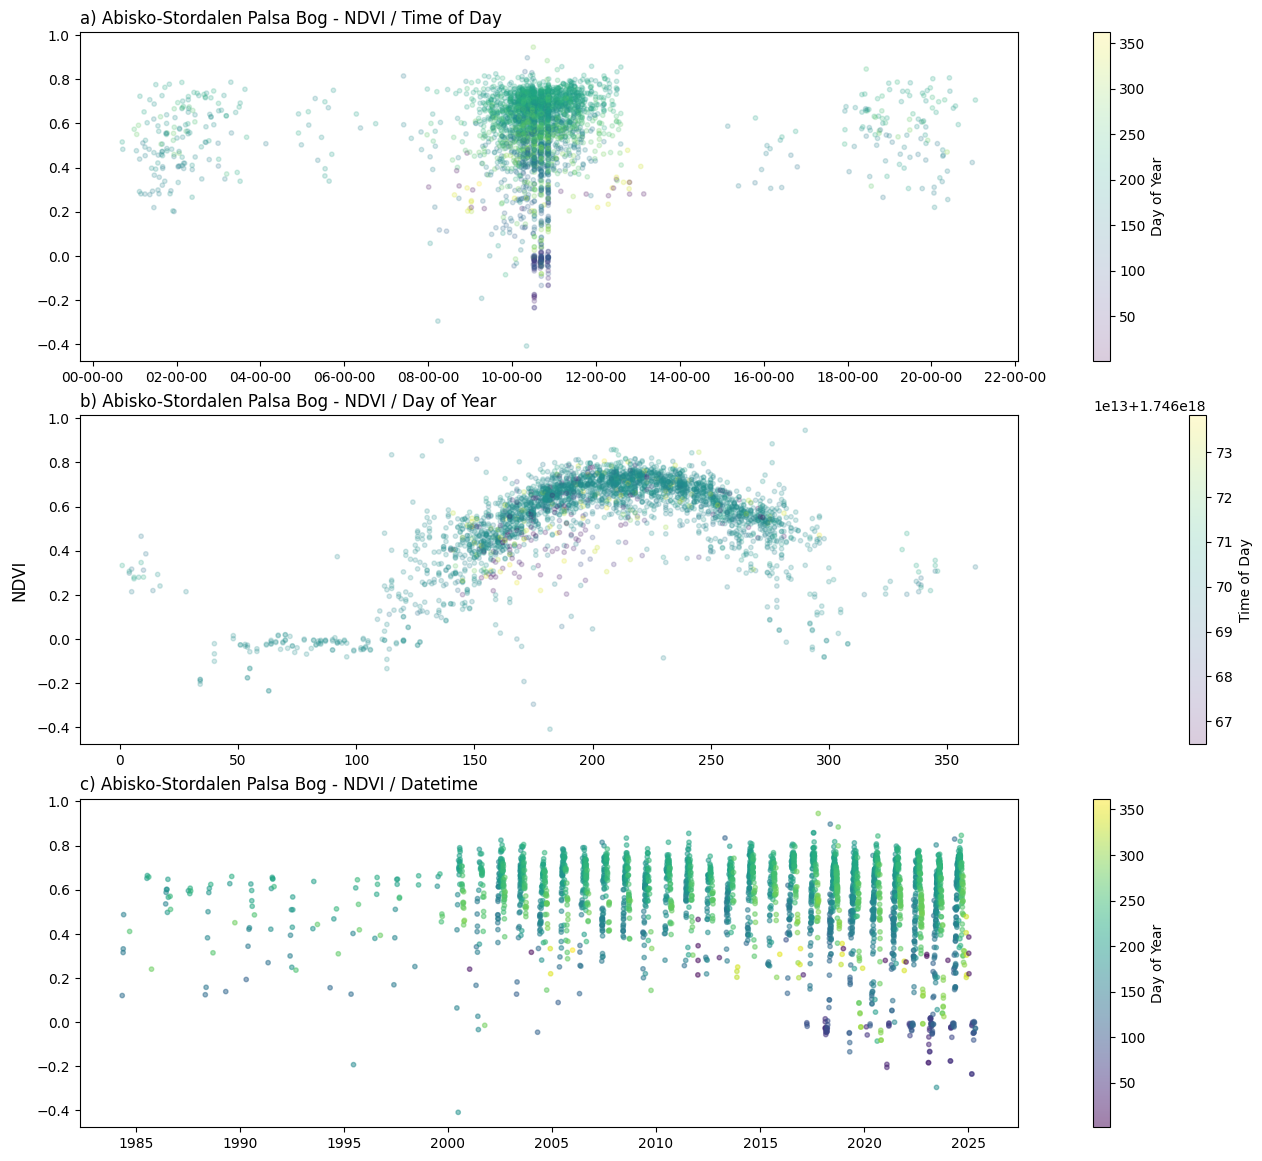

In [186]:
nrows = 3
ncols = 1
squish_factor = 4
fig, ax = plt.subplots(
    nrows = nrows, ncols=ncols,
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = False, constrained_layout=True
)
ax = ax.flatten()

sp0 = ax[0].scatter(
    x = satellite["Se_Sto"]["Time (Time of Day)"], y = satellite["Se_Sto"]["NDVI"],
    c = satellite["Se_Sto"]["Time (Day of Year)"], s = 10, alpha = 0.2, edgecolors = None,
)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H-%M-%S"))
ax[0].set_title("a) Abisko-Stordalen Palsa Bog - NDVI / Time of Day", loc = "left")
fig.colorbar(sp0, ax = ax[0], label = "Day of Year")

sp1 = ax[1].scatter(
    x = satellite["Se_Sto"]["Time (Day of Year)"], y = satellite["Se_Sto"]["NDVI"],
    c = satellite["Se_Sto"]["Time (Time of Day)"], s = 10, alpha = 0.2, edgecolors = None,
)
ax[1].set_title("b) Abisko-Stordalen Palsa Bog - NDVI / Day of Year", loc="left")
fig.colorbar(sp1, ax=ax[1], label="Time of Day")

sp2 = ax[2].scatter(
    x = satellite["Se_Sto"]["Time (Datetime)"], y = satellite["Se_Sto"]["NDVI"],
    c = satellite["Se_Sto"]["Time (Day of Year)"], s = 10, alpha = 0.5, edgecolors = None,
)
ax[2].set_title("c) Abisko-Stordalen Palsa Bog - NDVI / Datetime", loc="left")
fig.colorbar(sp2, ax=ax[2], label = "Day of Year")

fig.supylabel("NDVI")

Text(0.02, 0.5, 'Soil Moisture Index')

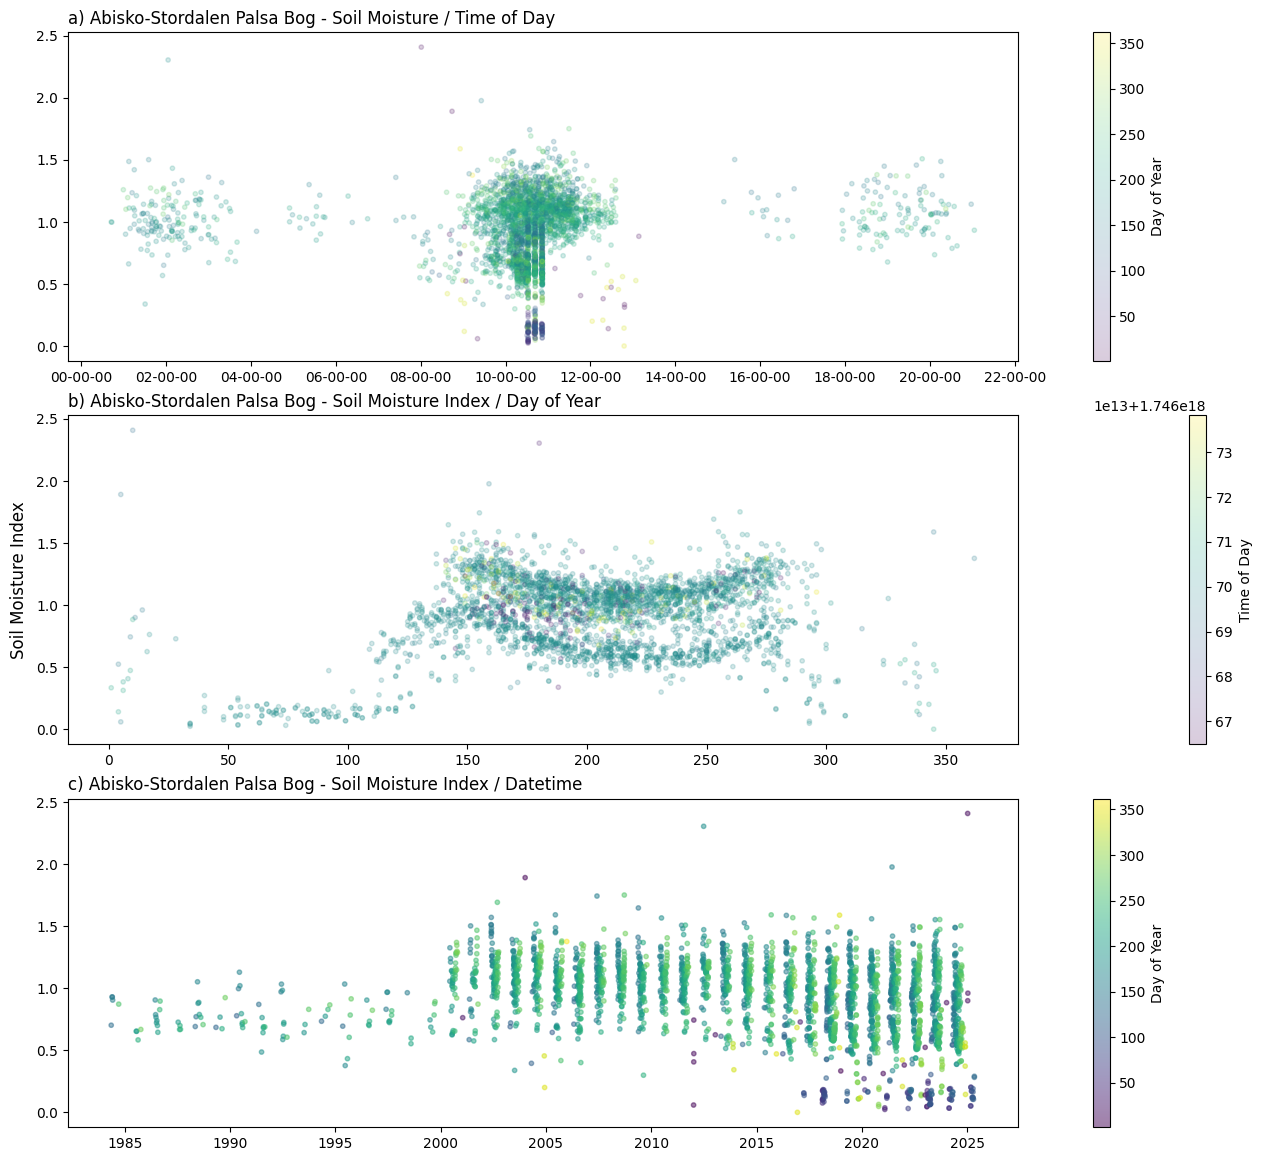

In [187]:
nrows = 3
ncols = 1
squish_factor = 4
fig, ax = plt.subplots(
    nrows = nrows, ncols=ncols,
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = False, constrained_layout=True
)
ax = ax.flatten()

sp0 = ax[0].scatter(
    x = satellite["Se_Sto"]["Time (Time of Day)"], y = satellite["Se_Sto"]["MSI"],
    c = satellite["Se_Sto"]["Time (Day of Year)"], s = 10, alpha = 0.2, edgecolors = None,
)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H-%M-%S"))
ax[0].set_title("a) Abisko-Stordalen Palsa Bog - Soil Moisture / Time of Day", loc = "left")
fig.colorbar(sp0, ax = ax[0], label = "Day of Year")

sp1 = ax[1].scatter(
    x = satellite["Se_Sto"]["Time (Day of Year)"], y = satellite["Se_Sto"]["MSI"],
    c = satellite["Se_Sto"]["Time (Time of Day)"], s = 10, alpha = 0.2, edgecolors = None,
)
ax[1].set_title("b) Abisko-Stordalen Palsa Bog - Soil Moisture Index / Day of Year", loc="left")
fig.colorbar(sp1, ax=ax[1], label="Time of Day")

sp2 = ax[2].scatter(
    x = satellite["Se_Sto"]["Time (Datetime)"], y = satellite["Se_Sto"]["MSI"],
    c = satellite["Se_Sto"]["Time (Day of Year)"], s = 10, alpha = 0.5, edgecolors = None,
)
ax[2].set_title("c) Abisko-Stordalen Palsa Bog - Soil Moisture Index / Datetime", loc="left")
fig.colorbar(sp2, ax=ax[2], label="Day of Year")

fig.supylabel("Soil Moisture Index")

# Processing

## Pair Satellite to Flux Tower Data Points

In [173]:
paired = {}

for location in satellite.keys():
    
    # Clip satellite to flux tower min and max times
    datetime_start = flux[location]["Time (Datetime)"].min()
    datetime_end = flux[location]["Time (Datetime)"].max()
    satellite[location] = satellite[location].dropna(subset = ["Time (Datetime)"])
    satellite_df_clip = satellite[location][(satellite[location]["Time (Datetime)"] >= datetime_start) & (satellite[location]["Time (Datetime)"] <= datetime_end)]
    
    # Merge Satellite and Flux data by nearest datetime column values
    merged = pd.merge_asof(
        satellite_df_clip, flux[location],
        left_on = "Time (Datetime)", right_on = "Time (Datetime)",
        direction = "nearest",
        suffixes = ("", "_flux") # keep satellite cols without suffix so that when we apply the random forest model we dont have to change col names. Append _flux to duplicate flux cols
    )
    
    paired[location] = merged

paired["Se_Sto"]

,Red (Rad),NIR (Rad),SWIR (Rad),Platform ID,Solar Elevation (Degrees),Solar Azimuth (Degrees),Time (Unix),Time (Datetime),Time (Time of Day),Time (Day of Year),...,Time (Unix)_flux,Soil Water Content Depth 1 (%),Soil Water Content Depth 2 (%),Soil Water Content Depth 3 (%),Soil Water Content Depth 4 (%),Soil Water Content Depth 5 (%),Soil Water Content Depth 6 (%),Gross Primary Production (µmol),Time (Time of Day)_flux,Time (Day of Year)_flux
0,0.002400,0.004200,0.001600,MYD09GA,-2.250000,200.330000,1.746707e+09,2022-01-06 12:17:54.289502636,2025-05-08 12:17:54.289502,6,...,1.746707e+09,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2025-05-08 12:30:00,6
1,0.864453,0.843725,0.129465,S2_SR_HARMONIZED,15.923601,174.853821,1.746700e+09,2022-03-05 10:31:53.343000000,2025-05-08 10:31:53.343000,64,...,1.746700e+09,NaN,NaN,NaN,NaN,NaN,NaN,0.088997,2025-05-08 10:30:00,64
2,0.874010,0.863960,0.140315,S2_SR_HARMONIZED,15.916325,173.610135,1.746700e+09,2022-03-05 10:31:56.964000000,2025-05-08 10:31:56.964000,64,...,1.746700e+09,NaN,NaN,NaN,NaN,NaN,NaN,0.088997,2025-05-08 10:30:00,64
3,0.893597,0.791430,0.024437,S2_SR_HARMONIZED,19.859918,175.392436,1.746700e+09,2022-03-15 10:31:53.452000000,2025-05-08 10:31:53.452000,74,...,1.746700e+09,NaN,NaN,NaN,NaN,NaN,NaN,0.055258,2025-05-08 10:30:00,74
4,0.898537,0.865735,0.106095,S2_SR_HARMONIZED,24.263447,181.571076,1.746702e+09,2022-03-26 10:51:41.465000000,2025-05-08 10:51:41.465000,85,...,1.746702e+09,NaN,NaN,NaN,NaN,NaN,NaN,0.122628,2025-05-08 11:00:00,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,0.000635,0.001500,0.000791,MYD09GA,-3.680000,215.350000,1.746709e+09,2024-11-26 13:04:10.783459641,2025-05-08 13:04:10.783459,331,...,1.746709e+09,1.31,3.04,0.02,15.58,49.26,52.81,0.000313,2025-05-08 13:00:00,331
867,0.005700,0.008600,0.003200,MOD09GA,-1.450000,157.894762,1.746695e+09,2024-11-28 08:56:32.129279110,2025-05-08 08:56:32.129279,333,...,1.746695e+09,1.39,3.04,0.00,15.53,49.30,52.55,0.000000,2025-05-08 09:00:00,333
868,0.001200,0.003400,0.001900,MYD09GA,-3.040000,210.830000,1.746708e+09,2024-11-28 12:45:20.645995868,2025-05-08 12:45:20.645995,333,...,1.746709e+09,1.30,2.96,0.00,15.32,49.23,52.41,0.000555,2025-05-08 13:00:00,333
869,0.002200,0.003400,0.001800,MOD09GA,-2.176190,158.250000,1.746695e+09,2024-12-03 08:59:27.413688439,2025-05-08 08:59:27.413688,338,...,1.746695e+09,0.14,0.74,0.00,13.67,48.59,50.48,0.000000,2025-05-08 09:00:00,338


Preview Relationship

Text(0.02, 0.5, 'Vegetation Index')

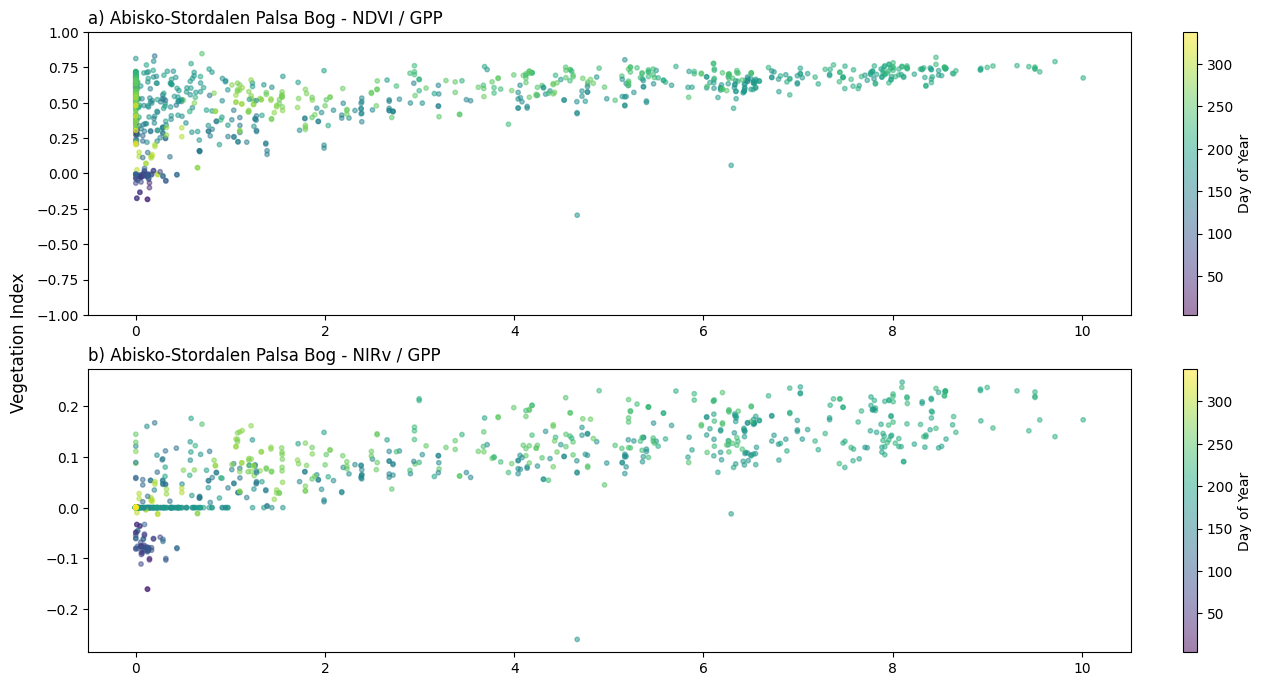

In [175]:
df = paired["Se_Sto"]

nrows = 2
ncols = 1
squish_factor = 1
fig, ax = plt.subplots(
    nrows = nrows, ncols=ncols,
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = False, constrained_layout=True
)
ax = ax.flatten()

sp0 = ax[0].scatter(
    x = df["Gross Primary Production (µmol)"], y = df["NDVI"],
    c = df["Time (Day of Year)"], s = 10, alpha = 0.5, edgecolors = None,
)
ax[0].set_title("a) Abisko-Stordalen Palsa Bog - NDVI / GPP", loc = "left")
ax[0].set_ylim(-1, 1)
fig.colorbar(sp0, ax = ax[0], label = "Day of Year")

sp1 = ax[1].scatter(
    x = df["Gross Primary Production (µmol)"], y = df["NIRv"],
    c = df["Time (Day of Year)"], s = 10, alpha = 0.5, edgecolors = None,
)
ax[1].set_title("b) Abisko-Stordalen Palsa Bog - NIRv / GPP", loc="left")
fig.colorbar(sp1, ax = ax[1], label = "Day of Year")

fig.supylabel("Vegetation Index")

Text(0.02, 0.5, 'Soil Moisture Index Index')

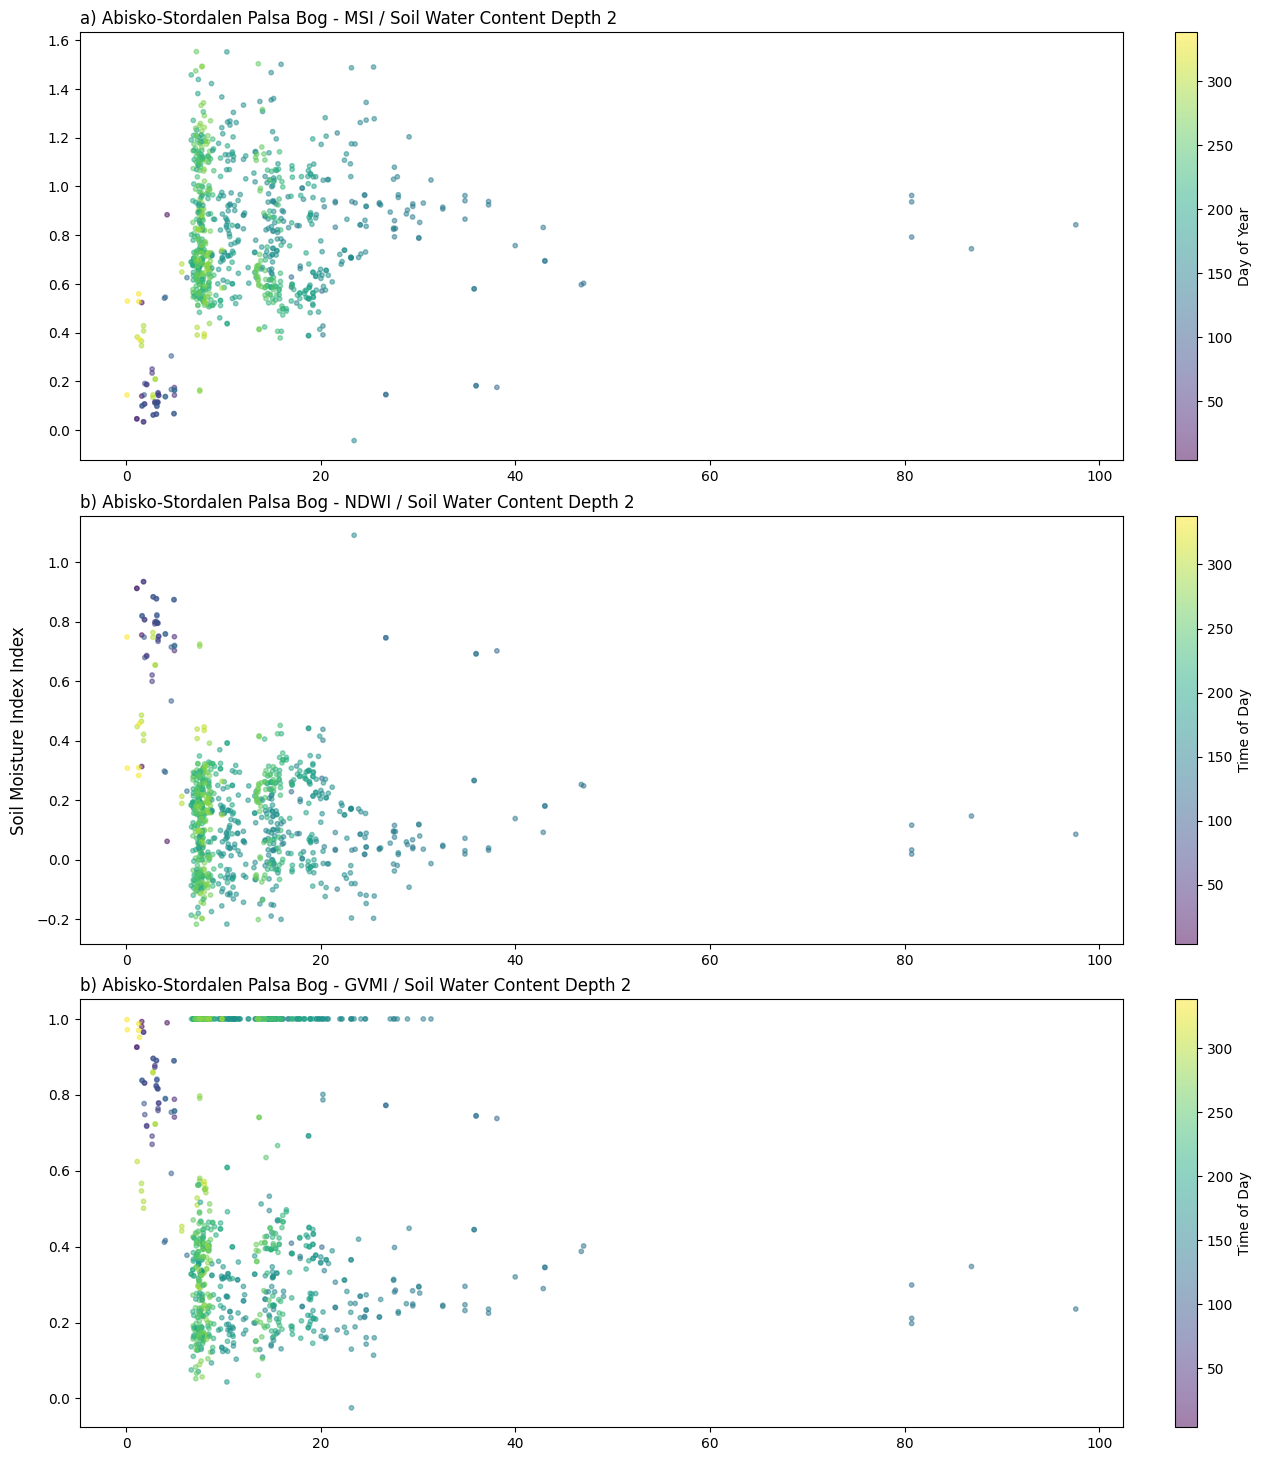

In [176]:
df = paired["Se_Sto"]

nrows = 3
ncols = 1
squish_factor = 1
fig, ax = plt.subplots(
    nrows = nrows, ncols=ncols,
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = False, constrained_layout=True
)
ax = ax.flatten()

sp0 = ax[0].scatter(
    x = df["Soil Water Content Depth 1 (%)"], y = df["MSI"],
    c = df["Time (Day of Year)"], s = 10, alpha = 0.5, edgecolors = None,
)
ax[0].set_title("a) Abisko-Stordalen Palsa Bog - MSI / Soil Water Content Depth 2", loc = "left")
fig.colorbar(sp0, ax = ax[0], label = "Day of Year")

sp1 = ax[1].scatter(
    x = df["Soil Water Content Depth 1 (%)"], y = df["NDWI"],
    c = df["Time (Day of Year)"], s = 10, alpha = 0.5, edgecolors = None,
)
ax[1].set_title("b) Abisko-Stordalen Palsa Bog - NDWI / Soil Water Content Depth 2", loc  ="left")
fig.colorbar(sp1, ax = ax[1], label = "Time of Day")

sp2 = ax[2].scatter(
    x = df["Soil Water Content Depth 1 (%)"], y = df["GVMI"],
    c = df["Time (Day of Year)"], s = 10, alpha = 0.5, edgecolors = None,
)
ax[2].set_title("b) Abisko-Stordalen Palsa Bog - GVMI / Soil Water Content Depth 2", loc = "left")
fig.colorbar(sp2, ax = ax[2], label = "Time of Day")

fig.supylabel("Soil Moisture Index Index")

## Train Random Forest Regressor

### Functions

In [177]:
def randomforest_train_prep(
    dataframe,
    training_features,
    target_feature,
    categorical_features = None,
    test_proportion = 0.2,
    seed = 2
):
    
    # One-hot Encode Categorical Variables
    dataframe = pd.get_dummies(dataframe, columns = categorical_features, drop_first = False)
    
    # Define your target
    target = target_feature

    # Select relevant features
    X = dataframe[training_features]
    y = dataframe[target]
    
    # Check for missing values
    #X = X.dropna()
    #y = y.loc[X.index]  # Ensure same indices
    
    # Drop rows where X or y have NaNs
    Xy = pd.concat([X, y], axis = 1).dropna()
    X = Xy[training_features]
    y = Xy[target_feature]
    
    # Split into train and test subsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_proportion, random_state = seed)
    
    return {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}

def randomforest_apply(
    dataframe,
    training_features,
    target_feature,
    categorical_features = None,
    test_proportion = 0.2,
    seed = 2
):
    
    # One-hot Encode Categorical Variables
    dataframe = pd.get_dummies(dataframe, columns = categorical_features, drop_first = False)
    
    # Select relevant features
    X = dataframe[training_features]
    
    # Predict using the trained model
    predictions = model.predict(dataframe[training_features])
    
    return predictions

### Run for GPP

R^2 Score: 0.9636239668208427
RMSE: 0.2999591394842924


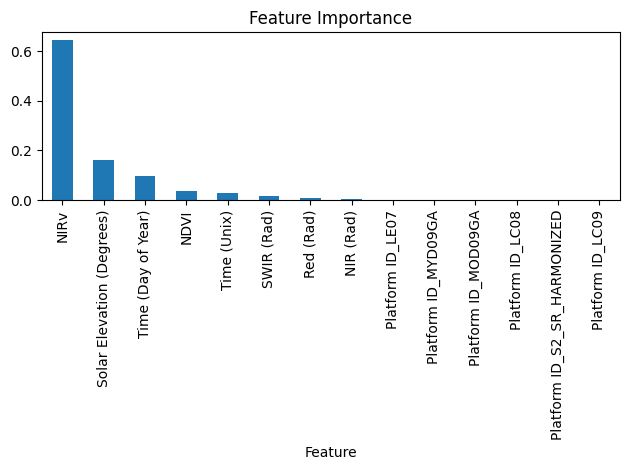

In [178]:
training_features = ["Red (Rad)", "NIR (Rad)", "SWIR (Rad)", "Solar Elevation (Degrees)", "Time (Day of Year)", "Time (Unix)", "Platform ID_LC08", "Platform ID_LC09", "Platform ID_LE07","Platform ID_S2_SR_HARMONIZED", "Platform ID_MOD09GA", "Platform ID_MYD09GA", "NDVI", "NIRv"]

randomforest_input = randomforest_train_prep(
    dataframe = paired["Se_Sto"],
    training_features = training_features,
    target_feature = "Gross Primary Production (µmol)",
    categorical_features = ["Platform ID"],
    test_proportion = 0.2
)

# Train and Fit Random Forest Regressor model
model = RandomForestRegressor(
    n_estimators = 1000,
    max_depth = None,
    min_samples_split = 2, min_samples_leaf=1,
    max_features = 1.0,
    bootstrap = True,
    random_state = 2)
model.fit(randomforest_input["X_train"], randomforest_input["y_train"])

# How good is the model?
y_pred = model.predict(randomforest_input["X_test"])
r2 = r2_score(randomforest_input["y_test"], y_pred)
rmse = mean_squared_error(randomforest_input["y_test"], y_pred)
print("R^2 Score:", r2)
print("RMSE:", rmse)

# What features were important?
importances = model.feature_importances_
feature_importance = pd.DataFrame({"Feature": training_features, "Importance": importances})
feature_importance.sort_values(by = "Importance", ascending = False, inplace = True)

feature_importance.plot(kind = "bar", x = "Feature", y = "Importance", legend=False)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

paired["Se_Sto_Forest"] = {
    "Model": model,
    "r2": r2,
    "RMSE": rmse,
    "training_features": training_features,
    "feature_importance": feature_importance
}

Apply Model to Rest of Timeseries

In [179]:
satellite["Se_Sto"]["Predicted Gross Primary Production (µmol)"] = randomforest_apply(
    dataframe = satellite["Se_Sto"],
    training_features = training_features,
    target_feature = "Gross Primary Production (µmol)",
    categorical_features = ["Platform ID"],
    test_proportion = 0.2
)

Preview Flux tower Informed Satellite GPP Estimate!

Text(0.02, 0.5, 'GPPe (µmol)')

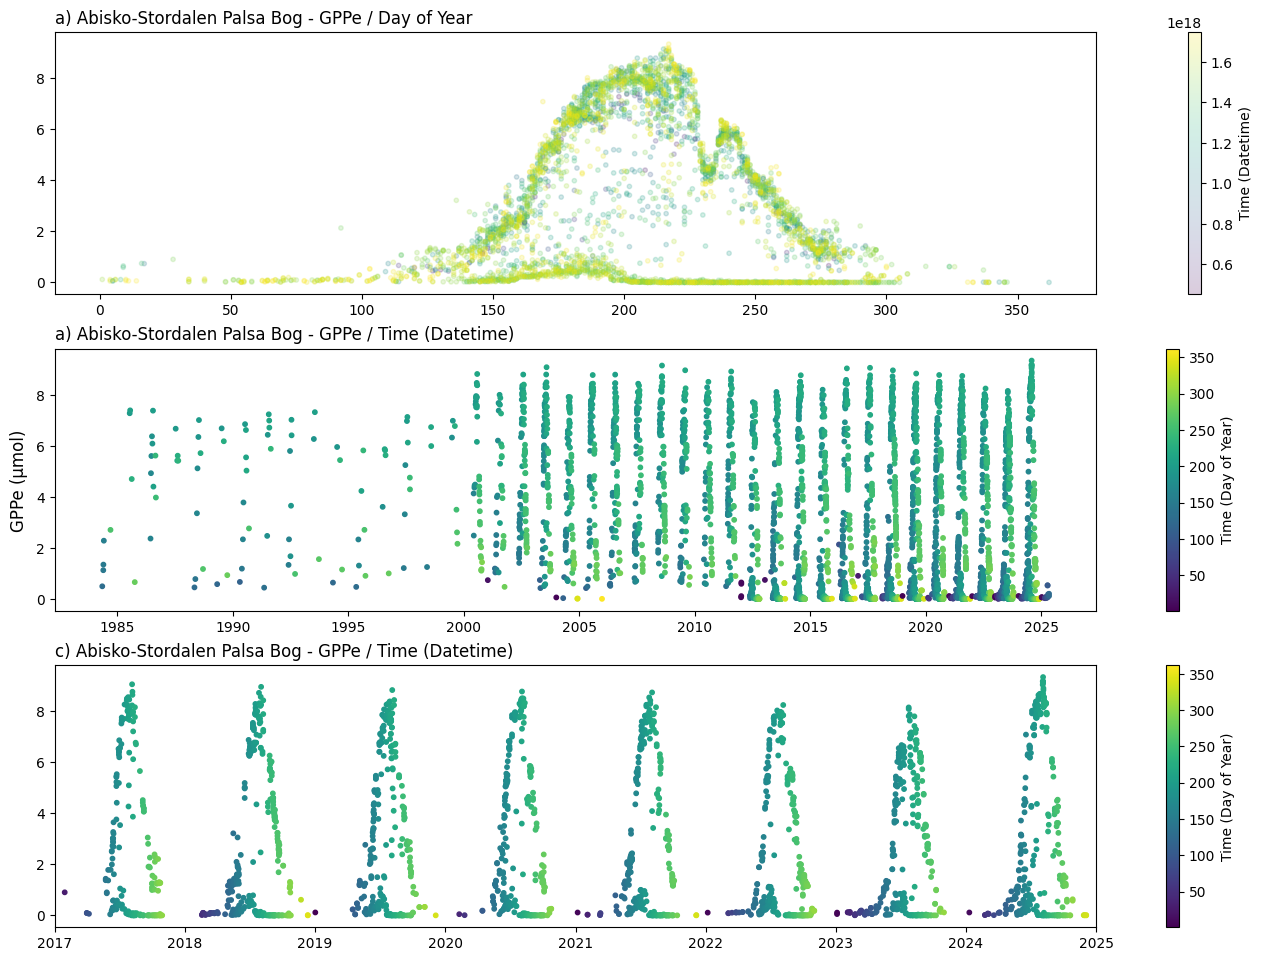

In [181]:
df = satellite["Se_Sto"]

nrows = 3
ncols = 1
squish_factor = 6
fig, ax = plt.subplots(
    nrows = nrows, ncols = ncols, 
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = False, constrained_layout = True
)
ax = ax.flatten()

sp0 = ax[0].scatter(
    x = df["Time (Day of Year)"], y = df["Predicted Gross Primary Production (µmol)"],
    c = df["Time (Datetime)"], s = 10, alpha = 0.2, edgecolors = None
)
ax[0].set_title("a) Abisko-Stordalen Palsa Bog - GPPe / Day of Year", loc = "left")
fig.colorbar(sp0, ax = ax[0], label = "Time (Datetime)")

sp1 = ax[1].scatter(
    df["Time (Datetime)"].sort_values(), df["Predicted Gross Primary Production (µmol)"],
    c = df["Time (Day of Year)"], alpha = 1, s = 10
)
fig.colorbar(sp1, ax = ax[1], label = "Time (Day of Year)")
ax[1].set_title("a) Abisko-Stordalen Palsa Bog - GPPe / Time (Datetime)", loc = "left")

sp2 = ax[2].scatter(
    df["Time (Datetime)"].sort_values(), df["Predicted Gross Primary Production (µmol)"],
    c = df["Time (Day of Year)"], alpha = 1, s = 10
)
fig.colorbar(sp2, ax = ax[2], label = "Time (Day of Year)")
ax[2].set_title("c) Abisko-Stordalen Palsa Bog - GPPe / Time (Datetime)", loc = "left")
ax[2].set_xlim(pd.Timestamp("2017-01-01"), pd.Timestamp("2025-01-01"))

fig.supylabel("GPPe (µmol)")

### Run for Soil Moisture

R^2 Score: 0.7870117642157415
RMSE: 9.333829592707945


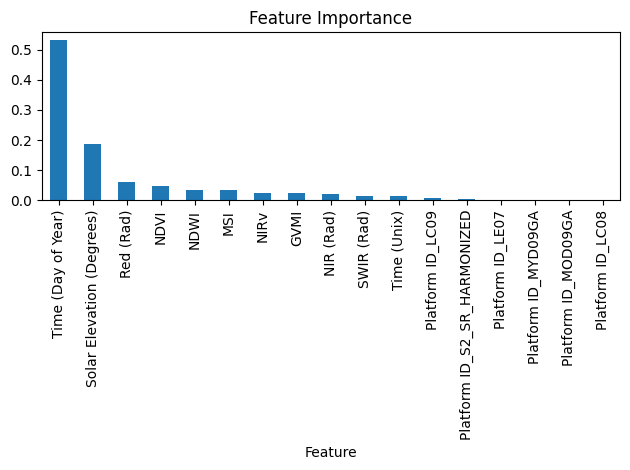

In [182]:
training_features = ["Red (Rad)", "NIR (Rad)", "SWIR (Rad)", "Solar Elevation (Degrees)", "Time (Day of Year)", "Time (Unix)", "Platform ID_LC08", "Platform ID_LC09", "Platform ID_LE07", "Platform ID_S2_SR_HARMONIZED", "Platform ID_MOD09GA", "Platform ID_MYD09GA", "MSI", "NDWI", "GVMI", "NDVI", "NIRv"]

randomforest_input = randomforest_train_prep(
    dataframe = paired["Se_Sto"],
    training_features = training_features,
    target_feature = "Soil Water Content Depth 2 (%)",
    categorical_features = ["Platform ID"],
    test_proportion = 0.2
)

# Train and Fit Random Forest Regressor model
model = RandomForestRegressor(
    n_estimators = 1000,
    max_depth = None,
    min_samples_split = 2, min_samples_leaf=1,
    max_features = 0.5,
    bootstrap = True,
    random_state = 2)
model.fit(randomforest_input["X_train"], randomforest_input["y_train"])

# How good is the model?
y_pred = model.predict(randomforest_input["X_test"])
r2 = r2_score(randomforest_input["y_test"], y_pred)
rmse = mean_squared_error(randomforest_input["y_test"], y_pred)
print("R^2 Score:", r2)
print("RMSE:", rmse)

# What features were important?
importances = model.feature_importances_
feature_importance = pd.DataFrame({"Feature": training_features, "Importance": importances})
feature_importance.sort_values(by = "Importance", ascending = False, inplace = True)

feature_importance.plot(kind = "bar", x = "Feature", y = "Importance", legend=False)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

paired["Se_Sto_Forest"] = {
    "Model": model,
    "r2": r2,
    "RMSE": rmse,
    "training_features": training_features,
    "feature_importance": feature_importance
}

Apply Model to Rest of Timeseries

In [183]:
satellite["Se_Sto"]["Soil Water Content Depth 2 (%)"] = randomforest_apply(
    dataframe = satellite["Se_Sto"],
    training_features = training_features,
    target_feature = "Soil Water Content Depth 2 (%)",
    categorical_features = ["Platform ID"],
    test_proportion = 0.2
)

Preview Flux tower Informed Satellite SWC Estimate!

Text(0.02, 0.5, 'SWCe (%)')

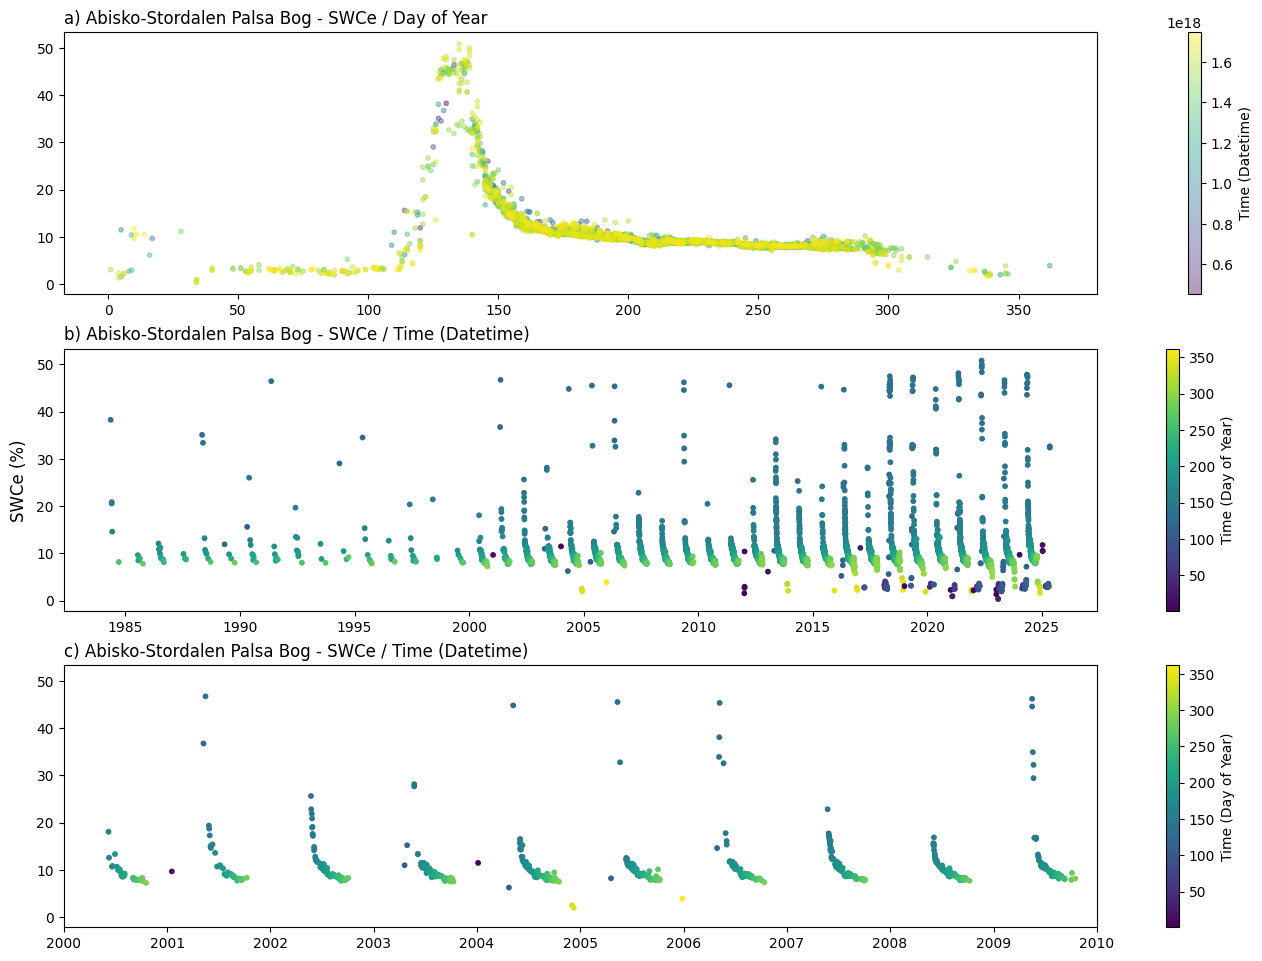

In [184]:
df = satellite["Se_Sto"]

nrows = 3
ncols = 1
squish_factor = 6
fig, ax = plt.subplots(
    nrows = nrows, ncols = ncols, 
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = False, constrained_layout = True
)
ax = ax.flatten()

sp0 = ax[0].scatter(
    x = df["Time (Day of Year)"], y = df["Soil Water Content Depth 2 (%)"],
    c = df["Time (Datetime)"], s = 10, alpha = 0.4, edgecolors = None
)
ax[0].set_title("a) Abisko-Stordalen Palsa Bog - SWCe / Day of Year", loc = "left")
fig.colorbar(sp0, ax = ax[0], label = "Time (Datetime)")

sp1 = ax[1].scatter(
    df["Time (Datetime)"].sort_values(), df["Soil Water Content Depth 2 (%)"],
    c = df["Time (Day of Year)"], alpha = 1, s = 10
)
fig.colorbar(sp1, ax=ax[1], label="Time (Day of Year)")
ax[1].set_title("b) Abisko-Stordalen Palsa Bog - SWCe / Time (Datetime)", loc = "left")

sp2 = ax[2].scatter(
    df["Time (Datetime)"].sort_values(), df["Soil Water Content Depth 2 (%)"],
    c = df["Time (Day of Year)"], alpha = 1, s = 10
)
fig.colorbar(sp2, ax = ax[2], label = "Time (Day of Year)")
ax[2].set_title("c) Abisko-Stordalen Palsa Bog - SWCe / Time (Datetime)", loc = "left")
ax[2].set_xlim(pd.Timestamp("2000-01-01"), pd.Timestamp("2010-01-01"))

fig.supylabel("SWCe (%)")